In [150]:
# standard 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sklearn
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
np.random.seed(41)

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [8]:
nfl = pd.read_csv('./data/nfl_7mva.csv', index_col = 'schedule_date')

In [10]:
nfl.drop(columns = 'Unnamed: 0', inplace = True)

In [12]:
# rows = 7 years data, 32 teams, 16 games, - 7 weeks for each team = - 224 rows = 3360
nfl.shape

(3360, 25)

In [13]:
nfl.columns

Index(['id', 'schedule_season', 'schedule_week', 'target_team', 'score',
       'opponent_score', 'opponent_team', 'win_margin', 'passing_yards',
       'rushing_yards', 'opp_passing_yards', 'opp_rushing_yards', 'home_team',
       'team_favorite_id', 'spread_favorite', 'over_under_line', 'game_number',
       'home_yes', 'pf_7mva', 'pa_7mva', 'margin_7mva', 'pyards_7mva',
       'ryards_7mva', 'opp_pyards_7mva', 'opp_ryards_7mva'],
      dtype='object')

#### Target is target team's score
#### Features are all the moving average columns and home_yes

In [57]:
X = nfl[['home_yes', 'pf_7mva', 'pa_7mva','margin_7mva', 'pyards_7mva',
       'ryards_7mva', 'opp_pyards_7mva', 'opp_ryards_7mva']]
y= nfl['score'] # 

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

### Set up Baseline where we just use the 7 week moving average of the score

In [86]:
baseline_preds = X_test['pf_7mva']

In [88]:
mean_absolute_error(y_test, baseline_preds)

8.045705782312925

#### Baseline MAE 8.05 

In [59]:
ss = StandardScaler()

In [60]:
X_train_scaled = ss.fit_transform(X_train, y_train)
X_test_scaled = ss.transform(X_test)

In [61]:
print(X_train_scaled.shape, X_test_scaled.shape)

(2688, 8) (672, 8)


### Linear Regression

In [62]:
lr = LinearRegression()

In [63]:
cross_val_score(lr, X_train_scaled, y_train)

array([0.13448707, 0.08498932, 0.09854023, 0.10377127, 0.18550651])

In [64]:
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [65]:
lr.score(X_train_scaled, y_train)

0.12597109104939164

In [66]:
lr.score(X_test_scaled, y_test)

0.1532281237439419

In [67]:
lr_preds = lr.predict(X_test_scaled)

In [68]:
mean_absolute_error(y_test, lr_preds)

7.38106278349165

#### Linear MAE: 7.38

In [69]:
lr.coef_

array([ 1.67140187, -0.21882288, -2.70620486,  1.36256094, -2.44926514,
       -2.69374153,  0.01742133, -1.61391005])

In [92]:
lr_coefs = pd.DataFrame(list(zip(X.columns, lr.coef_)))
lr_coefs_sorted = lr_coefs.sort_values(by = 1, ascending = False)
lr_coefs_sorted[1] = lr_coefs_sorted[1].round(decimals =1)
lr_coefs_sorted.rename(columns={0: 'Feature', 1: 'Coefficient'},inplace = True)
lr_coefs_sorted

,Feature,Coefficient
0,home_yes,1.7
3,margin_7mva,1.4
6,opp_pyards_7mva,0.0
1,pf_7mva,-0.2
7,opp_ryards_7mva,-1.6
4,pyards_7mva,-2.4
5,ryards_7mva,-2.7
2,pa_7mva,-2.7


### Ridge

In [73]:
ridgecv = RidgeCV(alphas = (0.1, 1.0, 10, 100, 1000), store_cv_values=True)

In [74]:
ridgecv.fit(X_train_scaled, y_train)

RidgeCV(alphas=array([1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
        store_cv_values=True)

In [75]:
ridgecv.alpha_

10.0

In [76]:
ridgecv.score(X_train_scaled, y_train)

0.12595591263322148

In [77]:
ridgecv.score(X_test_scaled, y_test)

0.1526691697812329

In [85]:
ridgecv.coef_

array([ 1.66683094, -0.21367901, -2.67704998,  1.34963593, -2.39876069,
       -2.64878052,  0.01637356, -1.58205327])

In [78]:
rpreds = ridgecv.predict(X_test_scaled)

In [90]:
mean_absolute_error(y_test, rpreds)

7.378956080607582

### MAE Ridge : 7.38

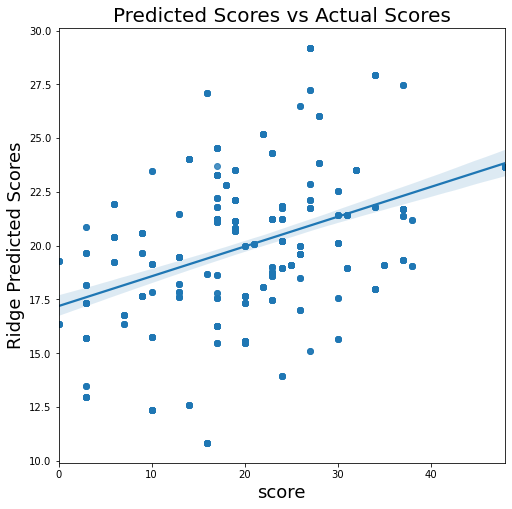

In [83]:
plt.figure(figsize = (8,8))
plt.title("Predicted Scores vs Actual Scores", fontsize=20)
plt.ylabel('Ridge Predicted Scores', fontsize=18)
plt.xlabel('Actual Scores', fontsize=18)
sns.regplot(y_test, rpreds);

In [94]:
r_coefs = pd.DataFrame(list(zip(X.columns, ridgecv.coef_)))
r_coefs_sorted = r_coefs.sort_values(by = 1, ascending = True)
r_coefs_sorted[1] = r_coefs_sorted[1].round(decimals =1)
r_coefs_sorted.rename(columns={0: 'Feature', 1: 'Coefficient'},inplace = True)
r_coefs_sorted

,Feature,Coefficient
2,pa_7mva,-2.7
5,ryards_7mva,-2.6
4,pyards_7mva,-2.4
7,opp_ryards_7mva,-1.6
1,pf_7mva,-0.2
6,opp_pyards_7mva,0.0
3,margin_7mva,1.3
0,home_yes,1.7


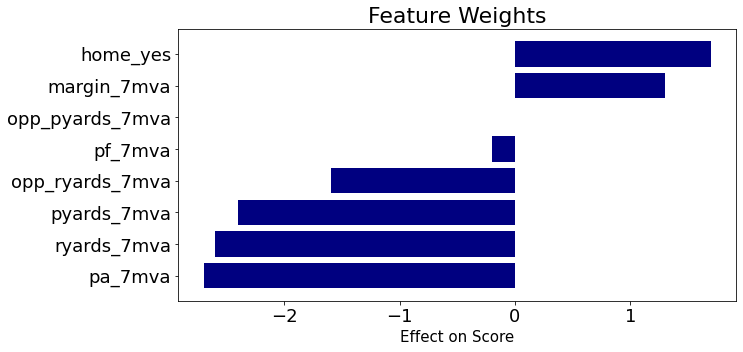

In [99]:
plt.figure(figsize = (10,5))
plt.barh(r_coefs_sorted['Feature'], r_coefs_sorted['Coefficient'], color='navy')
plt.title('Feature Weights', fontsize = 22)
plt.xlabel("Effect on Score",fontsize=15)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18);

### AdaBoost

In [101]:
boost = AdaBoostRegressor()

In [110]:
params = {'n_estimators': [100, 200, 500],
         'learning_rate': [10, 1.0, 0.1, 0.01, 0.05],
         'loss': ['linear', 'squared', 'exponential'] }

In [111]:
grid = GridSearchCV(boost, param_grid=params)

In [112]:
grid.fit(X_train, y_train)

GridSearchCV(estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [10, 1.0, 0.1, 0.01, 0.05],
                         'loss': ['linear', 'squared', 'exponential'],
                         'n_estimators': [100, 200, 500]})

In [113]:
grid.best_params_

{'learning_rate': 1.0, 'loss': 'exponential', 'n_estimators': 200}

In [114]:
grid.score(X_train, y_train)

0.6283385814833871

In [115]:
grid.score(X_test, y_test)

0.628133848909359

### Much better score

In [116]:
grid_preds = grid.predict(X_test)

In [117]:
mean_absolute_error(y_test, grid_preds)

5.279293373462386

In [147]:
best_boost = grid.best_estimator_

In [148]:
boost_df = pd.DataFrame({'features': X.columns, 'importance': best_boost.feature_importances_})

In [149]:
boost_df.sort_values('importance', ascending = False)

,features,importance
6,opp_pyards_7mva,0.185563
7,opp_ryards_7mva,0.150061
1,pf_7mva,0.142804
2,pa_7mva,0.136730
5,ryards_7mva,0.130870
3,margin_7mva,0.115906
4,pyards_7mva,0.110476
0,home_yes,0.027589


### Gradient Boosting

In [124]:
gboost = GradientBoostingRegressor()

In [134]:
params = {'loss': ['ls', 'huber'],
         'learning_rate': [0.05, 0.01, 0.4, 0.6], 
         'n_estimators': [10, 50, 75]}

In [135]:
boost_grid = GridSearchCV(gboost, param_grid=params)

In [136]:
boost_grid.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.01, 0.4, 0.6],
                         'loss': ['ls', 'huber'],
                         'n_estimators': [10, 50, 75]})

In [137]:
boost_grid.best_params_

{'learning_rate': 0.6, 'loss': 'ls', 'n_estimators': 75}

In [138]:
boost_grid.score(X_train, y_train)

0.9999951599972887

In [139]:
boost_grid.score(X_test, y_test)


0.9999939796462323

- too many estimators; learning rate went up when lowered them. (as expected)

In [140]:
best_ada = grid.best_estimator_

In [145]:
ada_df = pd.DataFrame({'features': X.columns, 'importance': best_ada.feature_importances_})

In [146]:
ada_df.sort_values('importance', ascending = False)

,features,importance
6,opp_pyards_7mva,0.185563
7,opp_ryards_7mva,0.150061
1,pf_7mva,0.142804
2,pa_7mva,0.136730
5,ryards_7mva,0.130870
3,margin_7mva,0.115906
4,pyards_7mva,0.110476
0,home_yes,0.027589


In [153]:
### below from lab

In [154]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=5)

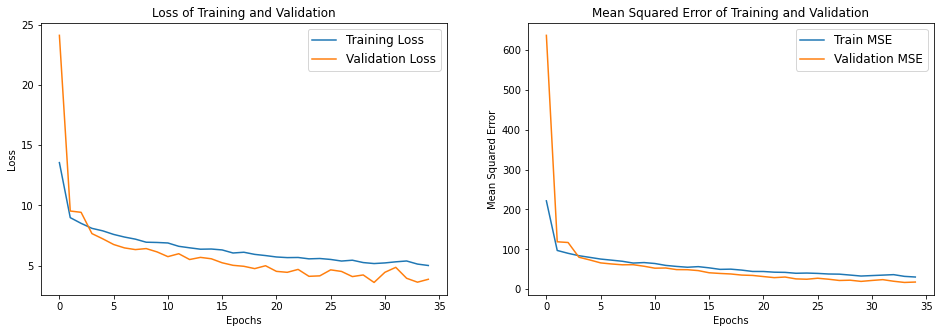

In [156]:
model_reg = Sequential()
model_reg.add(Input(shape=(8,)))
model_reg.add(BatchNormalization())
model_reg.add(Dense(64,activation='relu', kernel_regularizer=l2(0.01)))
model_reg.add(Dense(128, activation= 'relu', kernel_regularizer=l2(0.01)))
model_reg.add(Dropout(0.05))
model_reg.add(Dense(64,activation='relu', kernel_regularizer=l2(0.01)))
model_reg.add(Dropout(.20))
model_reg.add(Dense(1))

# compile
model_reg.compile(loss='mae', 
                optimizer='adam', 
                metrics=['mse'])

# fit model with early stopping
history_reg = model_reg.fit(X_train, y_train, 
                         validation_data=(X_test, y_test), 
                         epochs=100,
                         verbose=0,
                         callbacks=[early_stop])

# plot
fig, ax = plt.subplots(1, 2, figsize=(16,5))

plt.subplot(1, 2, 1)
plt.plot(history_reg.history['loss'], label='Training Loss');
plt.plot(history_reg.history['val_loss'], label='Validation Loss');
plt.legend(fontsize=12)
plt.title('Loss of Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss');


plt.subplot(1, 2, 2)
plt.plot(history_reg.history['mse'], label='Train MSE')
plt.plot(history_reg.history['val_mse'], label='Validation MSE')
plt.legend(fontsize=12)
plt.title('Mean Squared Error of Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error');

### ANN MAE: 5

In [163]:
history_reg.history['loss'][-1]

5.006916046142578

In [164]:
history_reg.history['mse'][-1]

30.65875816345215

In [165]:
seq_preds = model_reg.predict(X_test)

In [166]:
mean_absolute_error(y_test, seq_preds)

3.0012879485175725